In [1]:
# install dataset
#!/bin/bash
!curl -L -o facebook-hateful-meme-dataset.zip "https://www.kaggle.com/api/v1/datasets/download/parthplc/facebook-hateful-meme-dataset"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 3434M  100 3434M    0     0  73.2M      0  0:00:46  0:00:46 --:--:--  126M


In [2]:
# Extract the dataset
!unzip -q facebook-hateful-meme-dataset.zip -d hateful-memes
!ls -la hateful-memes

total 12
drwxr-xr-x 3 root root 4096 Mar 27 19:11 .
drwxr-xr-x 1 root root 4096 Mar 27 19:11 ..
drwxr-xr-x 3 root root 4096 Mar 27 19:12 data


In [3]:
# Install required packages
%pip install torch torchvision transformers scikit-learn matplotlib pandas numpy pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [4]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from torchvision import models, transforms
from transformers import BertTokenizer, BertModel

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [5]:
# Load the dataset
def load_jsonl(data_path):
    """
    Load a JSONL file (JSON Lines format) where each line is a valid JSON object.
    """
    data = []
    with open(data_path, 'r') as f:
        for line in f:
            line = line.strip()
            # Skip empty lines and comment lines
            if line and not line.startswith('//'):
                try:
                    data.append(json.loads(line))
                except json.JSONDecodeError as e:
                    print(f"Error parsing line: {line[:100]}...")
                    print(f"Error message: {str(e)}")
                    raise
    return data

train_data = load_jsonl('hateful-memes/data/train.jsonl')
dev_data = load_jsonl('hateful-memes/data/dev.jsonl')
test_data = load_jsonl('hateful-memes/data/test.jsonl')

print(f"Train samples: {len(train_data)}")
print(f"Dev samples: {len(dev_data)}")
print(f"Test samples: {len(test_data)}")

# Show an example
print("\nExample data point:")
print(train_data[0])

Train samples: 8500
Dev samples: 500
Test samples: 1000

Example data point:
{'id': 42953, 'img': 'img/42953.png', 'label': 0, 'text': 'its their character not their color that matters'}


In [6]:
# Create dataset class
class HatefulMemesDataset(Dataset):
    def __init__(self, data, img_dir='hateful-memes/data', transform=None, tokenizer=None):
        self.data = data
        self.img_dir = img_dir
        self.transform = transform
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]

        # Load image
        img_path = os.path.join(self.img_dir, item['img'])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        # Process text
        text = item['text']
        if self.tokenizer:
            encoded_text = self.tokenizer(text, padding='max_length', max_length=64, truncation=True, return_tensors='pt')
            input_ids = encoded_text['input_ids'].squeeze(0)
            attention_mask = encoded_text['attention_mask'].squeeze(0)
        else:
            input_ids = torch.tensor([0])
            attention_mask = torch.tensor([0])

        # Get label if available
        label = torch.tensor(item['label']) if 'label' in item else torch.tensor(-1)

        return {
            'image': image,
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'text': text,
            'label': label
        }

In [7]:
# Prepare data loaders
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_dataset = HatefulMemesDataset(train_data, transform=image_transforms, tokenizer=tokenizer)
dev_dataset = HatefulMemesDataset(dev_data, transform=image_transforms, tokenizer=tokenizer)
test_dataset = HatefulMemesDataset(test_data, transform=image_transforms, tokenizer=tokenizer)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [8]:
# Define the baseline model
class BaselineHatefulMemesModel(nn.Module):
    def __init__(self):
        super(BaselineHatefulMemesModel, self).__init__()

        # Image encoder - ResNet18 pretrained
        resnet = models.resnet18(pretrained=True)
        modules = list(resnet.children())[:-1]  # Remove the last FC layer
        self.image_encoder = nn.Sequential(*modules)
        for param in self.image_encoder.parameters():
            param.requires_grad = False

        # Text encoder - BERT
        self.text_encoder = BertModel.from_pretrained('bert-base-uncased')
        for param in self.text_encoder.parameters():
            param.requires_grad = False

        # Combined classifier
        self.classifier = nn.Sequential(
            nn.Linear(512 + 768, 256),  # ResNet18 features + BERT embeddings
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 1)
        )

    def forward(self, image, input_ids, attention_mask):
        # Extract image features
        image_features = self.image_encoder(image)
        image_features = image_features.view(image_features.size(0), -1)  # Flatten

        # Extract text features
        text_outputs = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask)
        text_features = text_outputs.pooler_output

        # Combine features
        combined_features = torch.cat((image_features, text_features), dim=1)

        # Classify
        output = self.classifier(combined_features)
        return output.squeeze(-1)

In [9]:
# Initialize model
model = BaselineHatefulMemesModel().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 64.8MB/s]


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [34]:
# Training function
def train_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    for batch in dataloader:
        images = batch['image'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].float().to(device)

        optimizer.zero_grad()
        outputs = model(images, input_ids, attention_mask)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        preds = torch.sigmoid(outputs) >= 0.5
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    return total_loss / len(dataloader), accuracy, f1

# Evaluation function
def evaluate(model, dataloader, criterion):
    model.eval().to(device)
    total_loss = 0
    all_preds = []
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].float().to(device)

            outputs = model(images, input_ids, attention_mask)
            loss = criterion(outputs, labels)

            total_loss += loss.item()

            probs = torch.sigmoid(outputs)
            preds = probs >= 0.5
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Add debugging information
    print(f"Prediction distribution: {sum(all_preds)}/{len(all_preds)} positive predictions")
    print(f"Label distribution: {sum(all_labels)}/{len(all_labels)} positive labels")
    print(f"Average predicted probability: {sum(all_probs)/len(all_probs):.4f}")

    # Handle edge cases
    if len(set(all_labels)) == 1:  # Only one class in labels
        print("WARNING: Only one class in labels - evaluation metrics will be affected")

    accuracy = accuracy_score(all_labels, all_preds)

    # Use different average parameter based on class presence
    if len(set(all_preds)) == 1 and len(set(all_labels)) == 1:
        f1 = 0 if all_preds[0] != all_labels[0] else 1
    else:
        f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    # Handle AUC calculation with error handling
    try:
        auc = roc_auc_score(all_labels, all_probs)
    except:
        auc = float('nan')
        print("AUC calculation failed - likely due to single class predictions")

    return total_loss / len(dataloader), accuracy, f1, auc

In [19]:
# Train the model
num_epochs = 5
train_losses = []
val_losses = []
best_auc = 0

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    # Train
    train_loss, train_acc, train_f1 = train_epoch(model, train_loader, optimizer, criterion)
    print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}, F1: {train_f1:.4f}")

    # Validate
    val_loss, val_acc, val_f1, val_auc = evaluate(model, dev_loader, criterion)
    print(f"Val Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}, F1: {val_f1:.4f}, AUC: {val_auc:.4f}")

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Save best model
    if val_auc > best_auc:
        best_auc = val_auc
        torch.save(model.state_dict(), 'best_baseline_model.pt')
        print("Saved best model!")

    print()

Epoch 1/5
Train Loss: 0.6094, Accuracy: 0.6691, F1: 0.3526
Val Loss: 0.7567, Accuracy: 0.5200, F1: 0.1429, AUC: 0.5828
Saved best model!

Epoch 2/5
Train Loss: 0.6070, Accuracy: 0.6753, F1: 0.3812
Val Loss: 0.7008, Accuracy: 0.5300, F1: 0.4226, AUC: 0.5794

Epoch 3/5
Train Loss: 0.6016, Accuracy: 0.6780, F1: 0.3906
Val Loss: 0.7125, Accuracy: 0.5320, F1: 0.3314, AUC: 0.5827

Epoch 4/5
Train Loss: 0.5995, Accuracy: 0.6791, F1: 0.4018
Val Loss: 0.7247, Accuracy: 0.5300, F1: 0.2943, AUC: 0.5800

Epoch 5/5
Train Loss: 0.5952, Accuracy: 0.6815, F1: 0.4197
Val Loss: 0.7931, Accuracy: 0.5180, F1: 0.1484, AUC: 0.5809



In [35]:
# Load best model and evaluate on test set
model.load_state_dict(torch.load('best_baseline_model.pt'))
test_loss, test_acc, test_f1, test_auc = evaluate(model, test_loader, criterion)

print(f"Test Results:")
print(f"Loss: {test_loss:.4f}")
print(f"Accuracy: {test_acc:.4f}")
print(f"F1 Score: {test_f1:.4f}")
print(f"AUC-ROC: {test_auc:.4f}")

Prediction distribution: 58/1000 positive predictions
Label distribution: -1000.0/1000 positive labels
Average predicted probability: 0.3115
Test Results:
Loss: -0.4600
Accuracy: 0.0000
F1 Score: 0.0000
AUC-ROC: nan


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


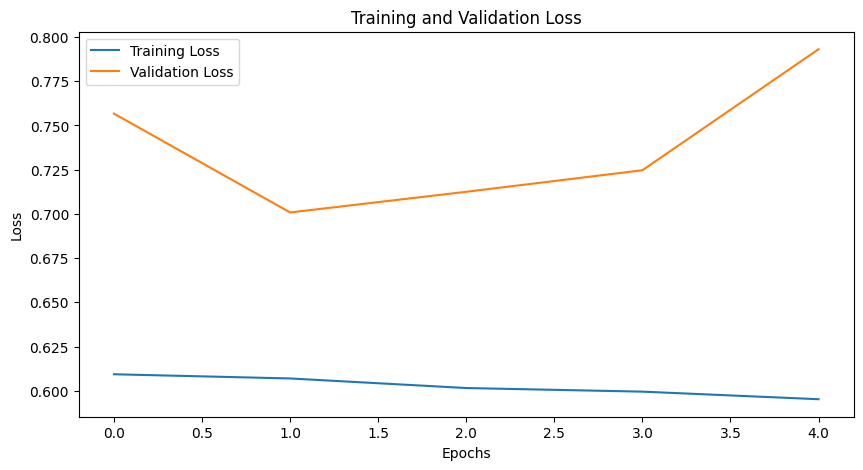

In [23]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [24]:
# Load the data using our new JSONL loader
train_data = load_jsonl('hateful-memes/data/train.jsonl')
dev_data = load_jsonl('hateful-memes/data/dev.jsonl')
test_data = load_jsonl('hateful-memes/data/test.jsonl')

print(f"Loaded {len(train_data)} training examples")
print(f"Loaded {len(dev_data)} validation examples")
print(f"Loaded {len(test_data)} test examples")

Loaded 8500 training examples
Loaded 500 validation examples
Loaded 1000 test examples


In [25]:
# Convert to dataframes for easier manipulation
train_df = pd.DataFrame(train_data)
dev_df = pd.DataFrame(dev_data)
test_df = pd.DataFrame(test_data)

# Display the first few rows of each dataset
print("Training data:")
display(train_df.head())
print("\nValidation data:")
display(dev_df.head())
print("\nTest data:")
display(test_df.head())

Training data:


,id,img,label,text
0,42953,img/42953.png,0,its their character not their color that matters
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...
2,13894,img/13894.png,0,putting bows on your pet
3,37408,img/37408.png,0,i love everything and everybody! except for sq...
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h..."



Validation data:


,id,img,label,text
0,8291,img/08291.png,1,white people is this a shooting range
1,46971,img/46971.png,1,bravery at its finest
2,3745,img/03745.png,1,your order comes to $37.50 and your white priv...
3,83745,img/83745.png,1,it is time.. to send these parasites back to t...
4,80243,img/80243.png,1,mississippi wind chime



Test data:


,id,img,text
0,16395,img/16395.png,handjobs sold seperately
1,37405,img/37405.png,introducing fidget spinner for women
2,94180,img/94180.png,happy pride month let's go beat up lesbians
3,54321,img/54321.png,laughs in [majority of u.s crime rate]
4,97015,img/97015.png,finds out those 72 virgins.. are goats


In [26]:
# Simple text-based baseline using a bag-of-words model
# Create a text vectorizer
vectorizer = CountVectorizer(max_features=5000, stop_words='english')

# Fit and transform the training text data
X_train = vectorizer.fit_transform(train_df['text'])
y_train = train_df['label']

# Transform the validation data
X_dev = vectorizer.transform(dev_df['text'])
y_dev = dev_df['label']

# Train a simple logistic regression model
classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train, y_train)

# Make predictions on validation data
y_pred = classifier.predict(X_dev)
y_pred_proba = classifier.predict_proba(X_dev)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_dev, y_pred)
auc = roc_auc_score(y_dev, y_pred_proba)

print(f"Text-only baseline results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"AUC: {auc:.4f}")

NameError: name 'CountVectorizer' is not defined

In [ ]:
# For test set predictions, assuming we want to make predictions
# Note that test.jsonl doesn't have labels so we can only generate predictions
X_test = vectorizer.transform(test_df['text'])
test_predictions = classifier.predict_proba(X_test)[:, 1]

# Create submission dataframe
submission_df = pd.DataFrame({
    'id': test_df['id'],
    'proba': test_predictions
})

submission_df.head()